In [1011]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import gamma, beta
from scipy.integrate import dblquad


import importlib

import base, bivariate, marginals, utils, tests, plots

importlib.reload(base)
importlib.reload(utils)
importlib.reload(bivariate)
importlib.reload(marginals)
importlib.reload(tests)
importlib.reload(plots)


plt.rcParams['figure.figsize'] = (6.4, 4.8)
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.dpi'] = 75

In [1012]:
#model = bivariate.StudentT(df = 5, Q = 0.7)
#model = bivariate.BivariateNormalMix(Q1 = 0.5, Q2 = -0.25, p = 0.1, adj = 1e-2)
model1 = bivariate.StudentT(Q = 0.5, df = 10)
#model2 = bivariate.Normal(Q = 0.5)

#model = bivariate.Clayton(alpha = 0.5)
#model = bivariate.Gumbel(delta = 1)

#model1 = bivariate.Normal(Q = 0.3)

In [1013]:
#u1_sim, u2_sim = bivariate.StudentT(df = 5, Q = 0.9).simulate(n = 10000)

#model = bivariate.Gumbel(delta = 1.5)
#u1_sim, u2_sim = model2.simulate(n = 500)

#model2 = bivariate.StudentT()
#model2.fit(u1_sim, u2_sim)

u1_sim, u2_sim = model1.simulate(n = 500)

model2 = bivariate.StudentT()
model2.fit(u1_sim, u2_sim)

In [1014]:
print(model2.summary())

                           Bivariate Copula Summary                           
Model Name:                  StudentT   Log-Likelihood:                64.9698
Model Family:              Elliptical   AIC:                          -60.9698
Method:                          CMLE   BIC:                         -117.5103
Num. Params:                        2   Kendall's Tau:                  0.3193
Num. Obs:                         500   Spearman's Rho:                    nan
Date:                Wed, Feb 07 2024   Upper Tail Depend.:                 NA
Time:                        00:28:47   Lower Tail Depend.:                 NA
                                                                              
                                                                              
                             Parameter Estimates                              
             coef    std err       h0          t       P>|t|    95% Conf. Int.
----------------------------------------------------

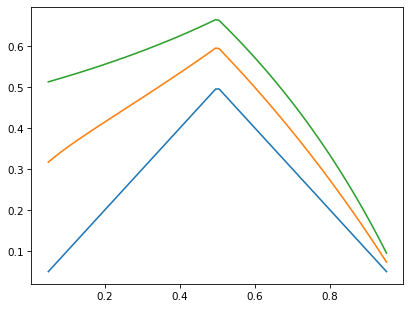

In [1015]:
q_range = utils.get_u_range(5e-2, range_num = 100)

f, ax = plt.subplots()
ax.plot(q_range, np.where(q_range > 0.5, 1 - q_range, q_range))

Q = -0.5
models = [bivariate.Clayton(alpha = 0.5),
          bivariate.Clayton(alpha = 1)]


for model in models:
    ax.plot(q_range, model.quantile_dependance(q_range))
    


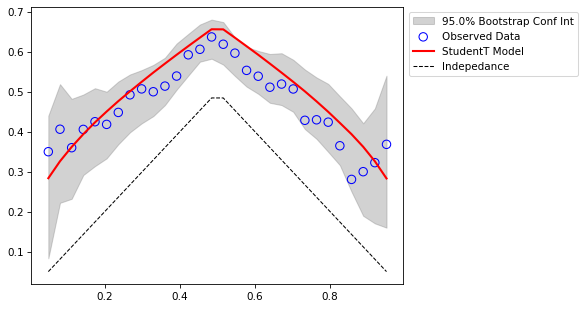

In [1016]:
ax = plots.quantile_dependance(u1_sim, u2_sim, copula = model1, copula_label = "StudentT Model", 
                               show_indep = True, boot = True)

In [1017]:
#print(model2.summary())

In [1018]:
#marginal1 = marginals.StudentT(mean = 2, stdev = 1)
#x1 = marginal1.simulate(n = 1000)


#marginal2 = marginals.StudentT()
#marginal2.fit(x1)

In [1019]:
#print(marginal2.summary())

In [1020]:
copula = bivariate.Clayton(alpha = 0.5)
u1, u2 = utils.get_u_grid()

<Axes3DSubplot:>

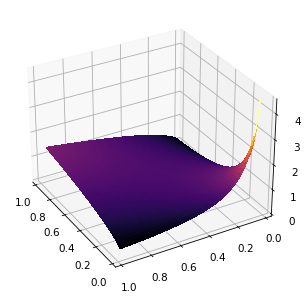

In [1021]:
vis.copula_3d_surf(copula, adj = 3e-2, azim = 150, elev = 30, cmap = "inferno")

<AxesSubplot:>

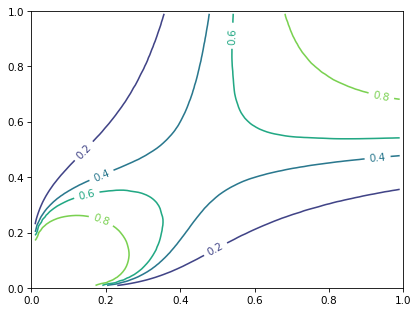

In [1022]:
vis.copula_contour(copula, num_levels = 5)

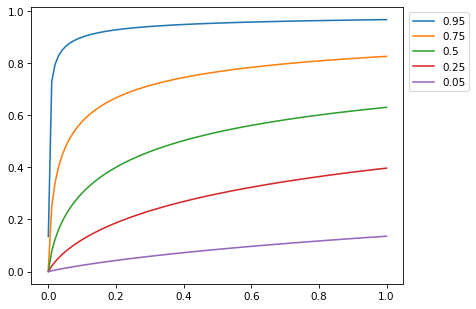

In [1023]:
ax = vis.copula_quantile_curves(copula)

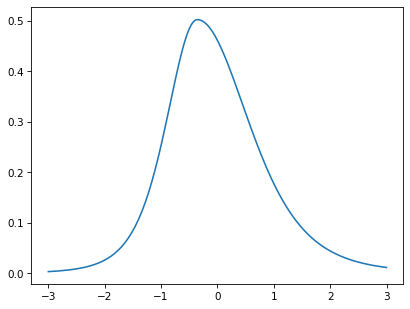

In [1024]:
def skew_student_t(z, eta, lam):
    const_C = gamma((eta + 1) / 2) / (np.sqrt(np.pi * (eta - 2)) * gamma(eta / 2))
    const_A = 4 * lam * const_C * (eta - 2) / (eta - 1)
    const_B = np.sqrt(1 + 3 * (lam**2) - (const_A ** 2))
    denom = np.where(z < -const_A/const_B, 1 - lam, 1 + lam)
    return const_B * const_C * np.power((1 + 1/(eta -2) * np.square((const_B * z + const_A)/denom)), -(eta+1)/2)


def sktcdf(z,nu,_lambda):
    '''
    % sktcdf(z,nu,lambda)
    % z      = Random Variable value (Between -inf and inf)
    % nu     = Kurtosis Parameter (>2 to inf)
    % lambda = Assymetry Parameter (-1 to 1)
    %
    % returns u = random Variable (between 0 and 1)
    %
    % Calculates the CDF for the skewed Student-t. Hansen (1994) version.
    % Author: Tino Contino
    % Date:   2 May 2021
    '''
    
    z  = np.atleast_1d(z)
    
    c = gamma((nu+1)/2)/(np.sqrt(np.pi*(nu-2))*gamma(nu/2))
    a = 4*_lambda*c*((nu-2)/(nu-1))
    b = np.sqrt(1 + 3 * _lambda**2 - a**2)
    
    limit_variable = -a/b
    lt = z < limit_variable
    gt = z >= limit_variable
    
    
    
    y_1 = (b*z+a) / (1-_lambda) * np.sqrt(nu/(nu-2))
    y_2 = (b*z+a) / (1+_lambda) * np.sqrt(nu/(nu-2))
    
    pdf1 = (1-_lambda) * stats.t.cdf(y_1, nu)
    pdf2 = (1-_lambda)/2 + (1+_lambda) * (stats.t.cdf(y_2, nu)-0.5)

    u = z.copy()

    u[lt] = pdf1[lt]
    u[gt] = pdf2[gt]

    return u

x_range = np.linspace(-3, 3, 200)

marginal = marginals.StandardSkewedT(5, 0.25)

pdf = skew_student_t(x_range, 5, 0.25)
f, ax = plt.subplots()
ax.plot(x_range, pdf)

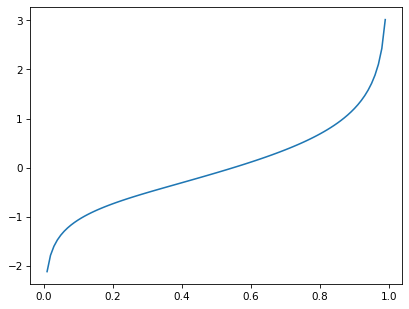

In [1030]:
u_range = utils.get_u_range(adj = 1e-2)

f, ax = plt.subplots()
ax.plot(u_range, marginal.ppf(u_range))

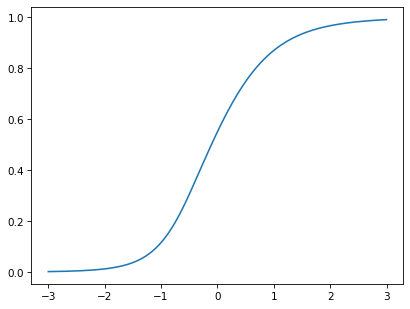

In [1026]:
plt.plot(x_range, sktcdf(x_range, 5, 0.25))
#plt.plot(x_range, sktcdf(x_range, 5, 0.9))

In [961]:
def skew_generalized_t(x, mu, sigma, lam, p, q):
    v = q**(-1/p) * ((3*lam**2 + 1)*(beta(3/p, q - 2/p)/beta(1/p,q)) - 4*lam**2*(beta(2/p, q - 1/p)/beta(1/p,q))**2)**(-1/2)

    m = 2*v*sigma*lam*q**(1/p)*beta(2/p,q - 1/p)/beta(1/p,q)   

    fx = p  / (2*v*sigma*q**(1/p)*beta(1/p,q)*(abs(x-mu+m)**p/(q*(v*sigma)**p)*(lam*np.sign(x-mu+m)+1)**p + 1)**(1/p + q))

    return fx
    

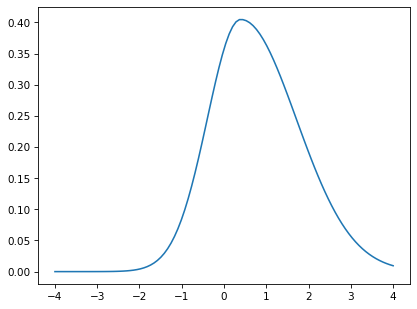

In [918]:
f, ax = plt.subplots()

pdf = skew_generalized_t(x_range, 0, 1, -0.25, 2, 1000)
ax.plot(x_range, pdf)